In [2]:
import os

import numpy as np
import numpy.ma as ma
import geopandas as gpd

import rasterio
import rasterio.plot
from rasterio.enums import Resampling
from pyproj import Transformer
from shapely.geometry.point import Point

from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

import contextily as cx
from tqdm import tqdm

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 7


def get_subarray_coords_rio (arr_shape, src_crs, trs, dest_crs = 4326):
    height = arr_shape[0]
    width = arr_shape[1]

    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(trs, rows, cols)

    xs = np.array(xs)
    ys = np.array(ys)

    trs_wgs = Transformer.from_crs (src_crs, dest_crs)
    lons, lats = trs_wgs.transform(xs,ys)
    return lons, lats


In [34]:
path2areas = r'D:\!Work\! Projects\2024- Плейстоценовый парк\ploshadki\ploshadki_park.shp'



# path2IR_rasters = [r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs\DJI_202404210937_006_Pleystocen-IR_t3dt.tif",
#                    r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs\DJI_202404211121_009_Pleystocen-IRb_t3dt.tif",
#                    r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs\DJI_202404221002_011_Pleystocen-IR3.tif",
#                    r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs\DJI_202404221002_011_Pleystocen-IR3_t3dt.tif",
#                    r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs\DJI_202404221218_016_Pleystocen-IR3b.tif",
#                    r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs\DJI_202404221218_016_Pleystocen-IR3b_t3dt.tif"]

path2IR_rasters = [r'G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs\DJI_202404230843_017_Pleystocen-IR5_t3dt.tif']

path2vis_rasters = [r'G:\! Data\IFA\! campaigns\202404 Pleistocene Park\orthophoto\geotiffs\DJI_202404210747_004_Pleystocen-big-vis_cr_wgs.tif',
                    r'G:\! Data\IFA\! campaigns\202404 Pleistocene Park\orthophoto\geotiffs\DJI_202404230952_020_Pleystocen-big-vis2_cr_wgs.tif']


polygons = gpd.read_file (path2areas)
polygons['coords'] = polygons['geometry'].apply(lambda x: x.representative_point().coords[:])
polygons['coords'] = [coords[0] for coords in polygons['coords']]
polygons['extent'] = [[p.bounds[0], p.bounds[2], p.bounds[1], p.bounds[3]] for p in polygons['geometry']]



In [4]:
    
ortho_rasters = []    
for path in path2vis_rasters:
    ortho_raster = {}
    src = rasterio.open(path)
    ortho_raster['fname'] = os.path.basename(path)
    ortho_raster['src'] = src
    ortho_raster['extent'] = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    ortho_rasters.append(ortho_raster)


ortho_min_lon = np.min([r['extent'][0] for r in ortho_rasters] + [p[0] for p in polygons['extent']])
ortho_max_lon = np.max([r['extent'][1] for r in ortho_rasters] + [p[1] for p in polygons['extent']])
ortho_min_lat = np.min([r['extent'][2] for r in ortho_rasters] + [p[2] for p in polygons['extent']])
ortho_max_lat = np.max([r['extent'][3] for r in ortho_rasters] + [p[3] for p in polygons['extent']])

ortho_lon_lim = np.array([ortho_min_lon - 0.01 * (ortho_max_lon - ortho_min_lon), ortho_max_lon + 0.01 * (ortho_max_lon - ortho_min_lon)])
ortho_lat_lim = np.array([ortho_min_lat - 0.01 * (ortho_max_lat - ortho_min_lat), ortho_max_lat + 0.01 * (ortho_max_lat - ortho_min_lat)])


In [14]:
pics_dir = 'pics_orthophoto'
if not os.path.isdir (pics_dir):
    os.mkdir(pics_dir)

upscale_factor = 10

for ortho_raster in ortho_rasters:
    ortho_src = ortho_raster['src']
    img = ortho_src.read(out_shape=(ortho_src.count,
                                    int(ortho_src.height / upscale_factor),
                                    int(ortho_src.width / upscale_factor)),
                        resampling=Resampling.bilinear)
    display(img.shape)  

    rgb_img = np.dstack((img[0,:,:],img[1,:,:],img[2,:,:],img[3,:,:]))
    n = np.sum (rgb_img[:,:,3] > 0)
    display(n)
    continue

    plt.figure(figsize=(5,7))
    plt.xlim(ortho_lon_lim)
    plt.ylim(ortho_lat_lim)
    cx.add_basemap(plt.gca(), source = cx.providers.Esri.WorldImagery, crs = 4326, attribution_size = 2)              
    
    plt.imshow(rgb_img, extent= ortho_raster['extent'] )
    
    polygons.plot (edgecolor = 'red', facecolor = 'None', ax = plt.gca())

    for idx, row in polygons.iterrows():
        plt.annotate(text=str(idx+1), xy=row['coords'],
                     horizontalalignment='center', color = 'red', fontsize = 10)

    points = gpd.GeoSeries([Point(161, ortho_lat_lim.mean()), Point(162, ortho_lat_lim.mean())], crs=4326)  # Geographic WGS 84 - degrees
    points = points.to_crs(32619)
    distance_meters = points[0].distance(points[1])

    scalebar = ScaleBar(distance_meters, length_fraction=0.25, location = 'lower right', pad = 0.2, border_pad = 0.5) #, units = "km", )
    plt.gca().add_artist(scalebar)                     
    
    plt.title(ortho_raster['fname'])
    plt.tight_layout()
    plt.savefig (pics_dir + '/' + ortho_raster['fname'] + '.png')
    
    

(4, 2099, 2502)

5229380

(4, 3580, 2335)

7149988

In [35]:


rasters = []

for path in path2IR_rasters:

    raster = {}

    display(path)

    src = rasterio.open(path)
    
    data = src.read() 
    values = data [0,:,:]
    mask = data [1,:,:]

    n = np.sum (mask > 0)
    display(n)
    

    raster['fname'] = os.path.basename(path)
    raster['values'] = ma.masked_array(values, ~mask.astype(bool))
    raster['extent'] = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    raster['lons'], raster['lats'] =  get_subarray_coords_rio (values.shape, src.crs, src.transform)
    raster['vmin2draw'] = np.nanpercentile(raster['values'].copy().filled(np.nan).flatten(), 1)
    raster['vmax2draw'] = np.nanpercentile(raster['values'].copy().filled(np.nan).flatten(), 99) #np.percentile(np.copy(raster['values'].flatten()), 99)
    rasters.append(raster)
    #break

'G:\\! Data\\IFA\\! campaigns\\202404 Pleistocene Park\\IR_mavic3\\geotiffs\\DJI_202404230843_017_Pleystocen-IR5_t3dt.tif'

21309927

In [37]:


rasters = []

for path in path2IR_rasters:

    raster = {}

    display(path)

    src = rasterio.open(path)
    
    data = src.read() 
    values = data [0,:,:]
    mask = data [1,:,:]
    raster['fname'] = os.path.basename(path)
    raster['values'] = ma.masked_array(values, ~mask.astype(bool))
    raster['extent'] = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    raster['lons'], raster['lats'] =  get_subarray_coords_rio (values.shape, src.crs, src.transform)
    raster['vmin2draw'] = np.nanpercentile(raster['values'].copy().filled(np.nan).flatten(), 1)
    raster['vmax2draw'] = np.nanpercentile(raster['values'].copy().filled(np.nan).flatten(), 99) #np.percentile(np.copy(raster['values'].flatten()), 99)
    rasters.append(raster)
    #break

'G:\\! Data\\IFA\\! campaigns\\202404 Pleistocene Park\\IR_mavic3\\geotiffs\\DJI_202404230843_017_Pleystocen-IR5_t3dt.tif'

In [38]:
min_lon = np.min([r['extent'][0] for r in rasters])
max_lon = np.max([r['extent'][1] for r in rasters])
min_lat = np.min([r['extent'][2] for r in rasters])
max_lat = np.max([r['extent'][3] for r in rasters])

ir_lon_lim = np.array([min_lon - 0.01 * (max_lon - min_lon), max_lon + 0.01 * (max_lon - min_lon)])
ir_lat_lim = np.array([min_lat - 0.01 * (max_lat - min_lat), max_lat + 0.01 * (max_lat - min_lat)])



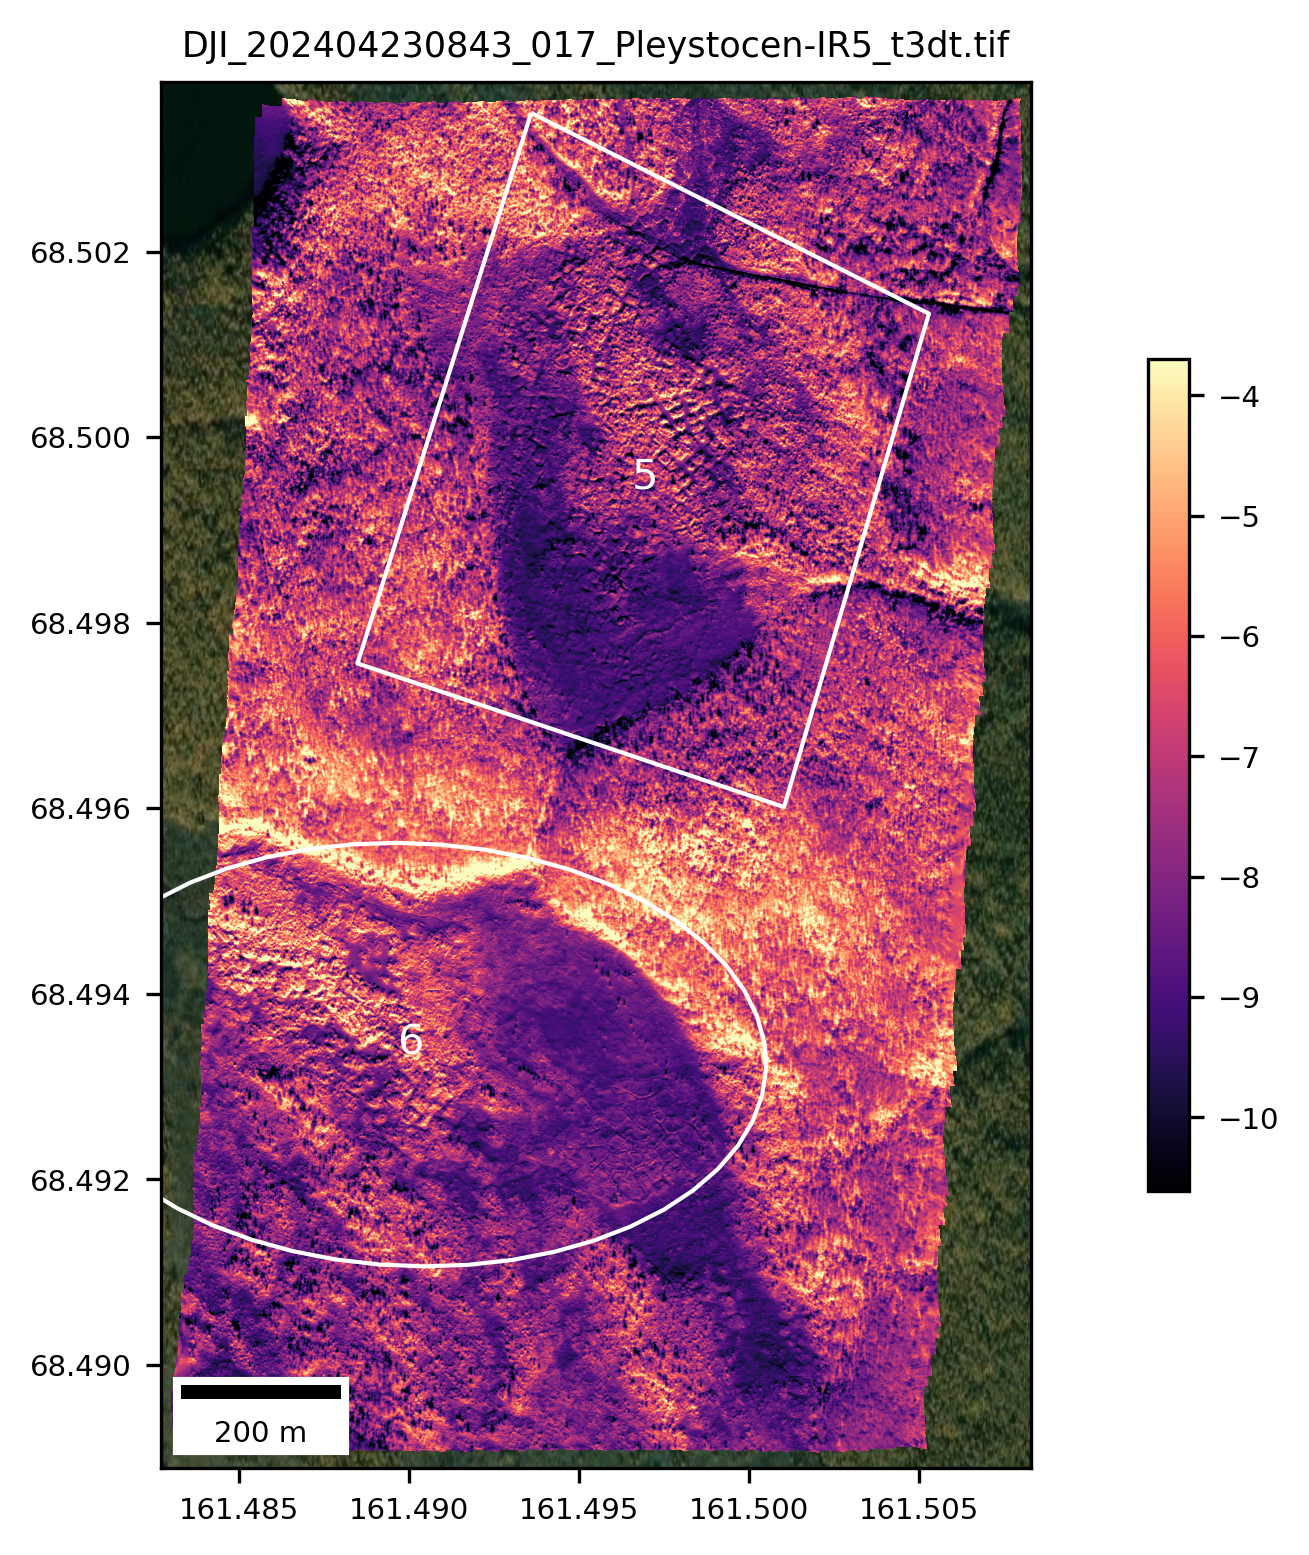

In [40]:
pics_dir = 'pics_IR'
if not os.path.isdir (pics_dir):
    os.mkdir(pics_dir)


for i, raster in enumerate (rasters):
    plt.figure(figsize = (10, 6))
    plt.xlim(ir_lon_lim)
    plt.ylim(ir_lat_lim)
    cx.add_basemap(plt.gca(), source = cx.providers.Esri.WorldImagery, crs = 4326, attribution_size = 2, attribution = '')              
    
    im = plt.imshow (raster['values'], extent= raster['extent'], vmin=raster['vmin2draw'], vmax=raster['vmax2draw'], cmap = 'magma')
    polygons.plot (edgecolor = 'white', facecolor = 'None', ax = plt.gca())
    for idx, row in polygons.iterrows():
        plt.annotate(text=str(idx+1), xy=row['coords'],
                    horizontalalignment='center', fontsize = 10, color = 'white')
    
    points = gpd.GeoSeries([Point(161, ir_lat_lim.mean()), Point(162, ir_lat_lim.mean())], crs=4326)  # Geographic WGS 84 - degrees
    points = points.to_crs(32619)
    distance_meters = points[0].distance(points[1])

    scalebar = ScaleBar(distance_meters, length_fraction=0.25, location = 'lower left', pad = 0.2, border_pad = 0.5) #, units = "km", )
    plt.gca().add_artist(scalebar)                     

    plt.title(raster['fname'])
    plt.colorbar(im, shrink = 0.6)
    #plt.tight_layout()
    plt.savefig (pics_dir + '/' + raster['fname'] + '.png')
    #break
#plt.gca().set_aspect(1.0/np.cos(lats.mean()*np.pi/180))